# Code - Section "Where"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
import fiona

In [2]:
df_police = pd.read_csv("ca_san_francisco_2020_04_01.csv")

/Users/siwei/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_locations = pd.DataFrame({'lat': df_police['lat'], 'lng': df_police['lng']})

In [4]:
df_locations.dropna(inplace=True)

In [5]:
shp = fiona.open("map/SFFind_Neighborhoods.shp")
bds = shp.bounds
shp.close()

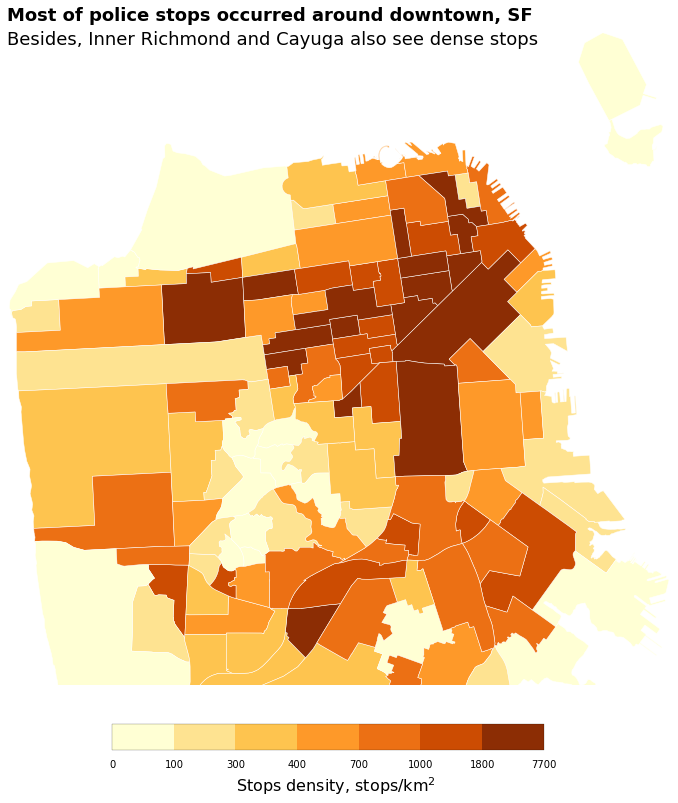

In [15]:
fig, ax = plt.subplots(figsize=(12,12))

colors = ["#ffffd4", "#fee391", "#fec44f", "#fe9929", "#ec7014", "#cc4c02", "#8c2d04"] # from colorbrewer2.org
bounds = [1,2,3,4,5,6,7,8]
boundaries = [0, 100, 300, 400, 700, 1000, 1800, 7700]

m = Basemap(
    llcrnrlon=bds[0],
    llcrnrlat=bds[1],
    urcrnrlon=bds[2],
    urcrnrlat=bds[3],
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    lat_ts=0,
    resolution='c',
    suppress_ticks=True
)

m.readshapefile(
    shapefile="map/SFFind_Neighborhoods",
    name='SF',
    color='none',
    zorder=2
)

# create d_map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'ward_name': [ward['name'] for ward in m.SF_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

# add patches column to the dataframe
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=4))

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df_locations['lng'], df_locations['lat'])])
stop_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))

# calculate points that fall within the boundary
sf_points = list(filter(wards_polygon.contains, stop_points))

# check if the lat/lon is contained in the district
df_map['count'] = df_map['poly'].map(lambda x: int(len(list(filter(prep(x).contains, sf_points)))))
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']

# add color label to df_
colors = ["#ffffd4", "#fee391", "#fec44f", "#fe9929", "#ec7014", "#cc4c02", "#8c2d04"] # from colorbrewer2.org
df_map["color"] = pd.qcut(df_map["density_km"], 7, labels=colors)
df_map["color"].values

# draw the patches to the map
pc = PatchCollection(df_map['patches'], match_original=True)
pc.set_facecolor(df_map['color'])
# pc.set_edgecolor(df_map['color'])
pc.set_edgecolor('white')
ax.add_collection(pc)


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

ax_c = fig.add_axes([0.25, 0.05, 0.5, 0.03])

cmap = mpl.colors.ListedColormap(colors)
cb2 = ColorbarBase(ax_c, cmap=cmap,
                  boundaries=bounds,
                  ticks=bounds,
                  label=boundaries,
                  orientation='horizontal')
cb2.set_label("")
cb2.set_ticklabels(boundaries)
cb2.outline.set_linewidth(0.2)
cb2.ax.tick_params(length=5, width=1, direction = 'out', color='w')
cb2.ax.xaxis.set_label_position('top')
ax_c.text(3, -10, 'Stops density, stops/km$^2$', fontsize=16)

ax.text(0,14000, "Most of police stops occurred around downtown, SF", fontweight='bold', fontsize=18)
ax.text(0,13500, "Besides, Inner Richmond and Cayuga also see dense stops", fontsize=18)

plt.show()